# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: CodeChallenge: Effects of mini-batch size
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [24]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

C:\Users\U7W20E6\AppData\Local\Temp/ipykernel_2504/1094594094.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Things related to data

In [25]:
# import dataset (comes with seaborn)
import pandas as pd
from scipy import stats

wine_data = pd.read_csv('../seaborn-data-master/winequality-red.csv', sep=';')
wine_data['quality_bin'] = (wine_data['quality'] > 5).astype(float)
wine_data = wine_data.drop('quality', axis=1)

wine_data = wine_data[wine_data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = wine_data.keys()
cols2zscore = cols2zscore.drop('quality_bin')
wine_data[cols2zscore] = wine_data[cols2zscore].apply(stats.zscore)

In [26]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_bin
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,0.0
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,0.0
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,0.0
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,1.0
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,0.0


In [27]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(wine_data[cols2zscore].values).float()
labels = torch.tensor(wine_data['quality_bin'].values).float()
labels = labels.reshape((len(labels), 1))

In [28]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=.9)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset  = TensorDataset(test_data, test_labels)

# Things related to the model

In [29]:
# a function that creates the ANN model

def createANewModel():
  model = nn.Sequential(
      nn.Linear(11, 64),   # input layer
      nn.ReLU(),          # activation unit
      # nn.Linear(16, 32),   # input layer
      # nn.ReLU(),          # activation unit
      nn.Linear(64, 64),  # hidden layer
      nn.ReLU(),          # activation unit
      nn.Linear(64, 1),   # output units
  )

  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=.01)
  return model, lossfun, optimizer

In [1]:
# train the model

# global parameter
numepochs = 100

def trainTheModel(model, lossfun, optimizer):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for _ in range(numepochs):

    # activate training mode
    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X, y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat, y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())
      batchLoss.append(loss.item())
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    ### test accuracy
    
    # extract X,y from test dataloader
    X, y = next(iter(test_loader))

    # activate testing mode
    model.eval()
    with torch.no_grad():
      predlabels = (model(X) > 0).float()
    
    # compute accuracy
    testAcc.append(100*torch.mean((predlabels == y).float()).item())

  # function output
  return trainAcc, testAcc, losses


# Run the experiment and visualize the results

In [37]:
# range of batch sizes
# batchsizes = 2**np.arange(1,7)
batchsizes = [2, 64, 512]

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))
lossResultsTrain = np.zeros((numepochs,len(batchsizes)))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

  # create dataloader object
  train_loader = DataLoader(
    train_dataDataset,
    batch_size=int(batchsizes[bi]),
    shuffle=True,
    drop_last=True
  )

  # create and train a model
  model, lossfun, optimizer = createANewModel()
  trainAcc, testAcc, losses = trainTheModel(model, lossfun, optimizer)

  # store results
  accuracyResultsTrain[:, bi] = trainAcc
  lossResultsTrain[:, bi] = losses
  accuracyResultsTest[:, bi]  = testAcc

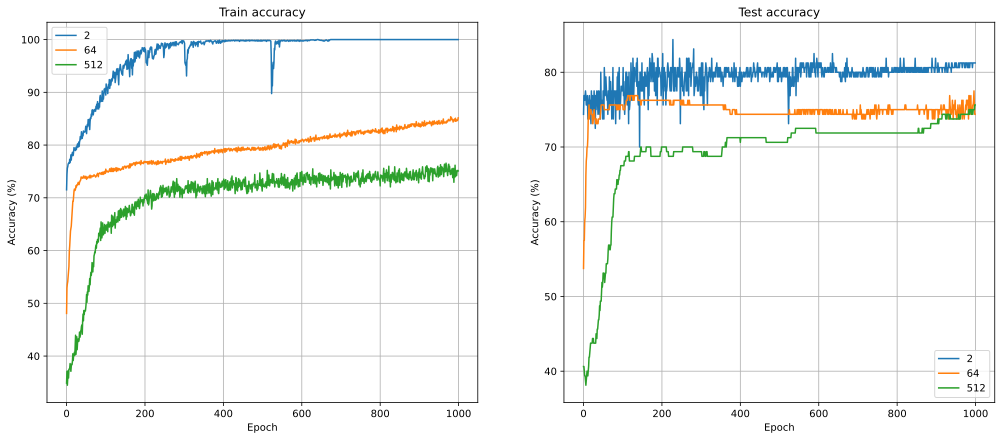

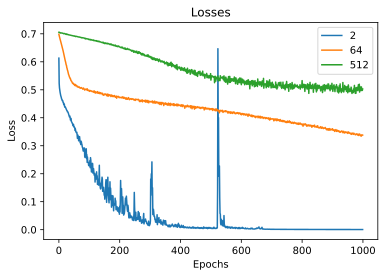

In [40]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  # ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()


fig, ax = plt.subplots(1, 1)
ax.plot(lossResultsTrain)
ax.legend(batchsizes)
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Additional explorations

In [33]:
# 1) Why are the minibatch sizes specified in powers of 2? That's partly because DL is developed by math/computer nerds,
#    but it's also partly an attempt to optimize computation speed, because computer memory comes in powers of two.
#    But 2**N is not a specific requirement. Adjust the code to use batch sizes corresponding to six linearly spaced 
#    integers between 2 and 50.
# 
# 2) Why did I ask you to set the learning rate to .001? Try this experiment again using higher and lower learning rates.
#    What do you conclude about batch sizes and learning rate?
# 